In [1]:
!pip install -U irbasis3 xprec

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
!pip install jaxlib jax

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

import irbasis3
from numpy.polynomial.legendre import leggauss
from itertools import product

In [4]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
from jax import grad, jit, vmap

In [5]:
def scale_quad(x, w, xmax, xmin):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

def _test_scale_quad():
    """ Integrate x^3 over [3, 0] """
    xmax = 3
    x_, w_ = leggauss(10)
    x, w = scale_quad(x_, w_, xmax, 0)
    f = lambda x: x**3
    res = np.sum(w * f(x))
    ref = 0.25*(xmax**4)
    assert np.abs(res - ref) < 1e-10

_test_scale_quad()

In [6]:
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-15)
print("dim", basis.size)
basis.s/basis.s[0]

dim 40


array([1.00000000e+00, 8.53837813e-01, 5.49145196e-01, 3.67374336e-01,
       2.19553524e-01, 1.29444220e-01, 7.30944043e-02, 4.02142528e-02,
       2.15029940e-02, 1.12086848e-02, 5.69932115e-03, 2.82957230e-03,
       1.37249433e-03, 6.50755177e-04, 3.01730842e-04, 1.36855975e-04,
       6.07396214e-05, 2.63844592e-05, 1.12196967e-05, 4.67141750e-06,
       1.90467209e-06, 7.60604097e-07, 2.97524206e-07, 1.14016108e-07,
       4.28098161e-08, 1.57509087e-08, 5.67942613e-09, 2.00720459e-09,
       6.95375963e-10, 2.36179493e-10, 7.86528074e-11, 2.56857635e-11,
       8.22688396e-12, 2.58465854e-12, 7.96632511e-13, 2.40915029e-13,
       7.14967895e-14, 2.08254045e-14, 5.95461498e-15, 1.67162105e-15])

In [7]:
dim = basis.size
u = basis.u
v = basis.v
svals = basis.s

In [8]:
roots = v[-1].roots()
smpl_points = np.hstack((-wmax, roots, wmax))
nsp = smpl_points.size
smpl_points

array([-1.00000000e+01, -9.93676657e+00, -9.67350831e+00, -9.22553225e+00,
       -8.63084165e+00, -7.93380965e+00, -7.17798072e+00, -6.40103377e+00,
       -5.63233177e+00, -4.89262667e+00, -4.19511422e+00, -3.54707834e+00,
       -2.95159854e+00, -2.40904184e+00, -1.91824668e+00, -1.47742328e+00,
       -1.08487643e+00, -7.39797077e-01, -4.43669572e-01, -2.00366934e-01,
       -1.17266461e-15,  2.00366934e-01,  4.43669572e-01,  7.39797077e-01,
        1.08487643e+00,  1.47742328e+00,  1.91824668e+00,  2.40904184e+00,
        2.95159854e+00,  3.54707834e+00,  4.19511422e+00,  4.89262667e+00,
        5.63233177e+00,  6.40103377e+00,  7.17798072e+00,  7.93380965e+00,
        8.63084165e+00,  9.22553225e+00,  9.67350831e+00,  9.93676657e+00,
        1.00000000e+01])

In [9]:
# Projector from sampled values to rho_l
prj = np.zeros((svals.size, nsp))

x_, w_ = leggauss(10)

for s in range(nsp-1):
    x, w = scale_quad(x_, w_, smpl_points[s+1], smpl_points[s])
    dx = smpl_points[s+1] - smpl_points[s]
    f = (x - smpl_points[s])/dx
    g = ( smpl_points[s+1] - x)/dx
    for l in range(svals.size):
        prj[l, s+1] += np.sum(w * v[l](x) * f)
        prj[l, s] += np.sum(w * v[l](x) * g)

print("cond: ", np.linalg.cond(prj))

cond:  14.762443838747311


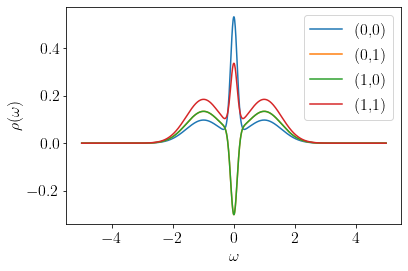

In [10]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

theta = 0.2*np.pi
rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def rho(omega):
    rho_omega = np.zeros((omega.size, 2, 2))
    rho_omega[:,0,0] = 0.2*gaussian(omega, 0.0, 0.15)
    rho_omega[:,1,1] = 0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)
    return np.einsum('ji,wjk,kl->wil', rot_mat, rho_omega, rot_mat)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
rho_omega = rho(omegas)
for i, j in product(range(2),repeat=2):
    plt.plot(omegas, rho_omega[:,i,j], label=f'({i},{j})')
plt.legend()

In [11]:
#def test_positive_definite():
#    rho_omega_ = rho(smpl_points)
#    for i in range(smpl_points.size):
#        #evals, _ = np.linalg.eig(rho_omega_)
#        print(rho_omega_[i,:,:])
#
#test_positive_definite()

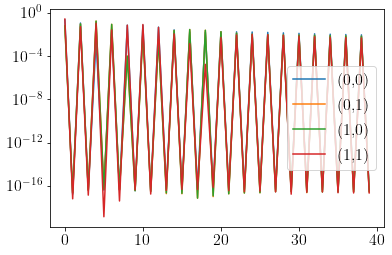

In [12]:
# Expand the spectral function in IR
x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, wmax, -wmax)
all_l = np.arange(svals.size)

rhol = np.einsum('lw,w,wij->lij', v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)

for i, j in product(range(2),repeat=2):
    plt.semilogy(np.abs(rhol[:,i,j]), label=f'({i},{j})')
plt.legend()

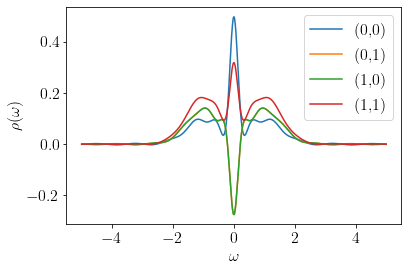

In [13]:
rho_reconst = np.einsum('lw,lij->wij', v.value(all_l[:,None], omegas[None,:]), rhol)

plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
rho_omega = rho(omegas)
for i, j in product(range(2),repeat=2):
    plt.plot(omegas, rho_reconst[:,i,j], label=f'({i},{j})')
plt.legend()

In [14]:
gl = - np.einsum('l,lij->lij', svals, rhol)

$$
\frac{1}{2} \sum_l |g_l + S_l \rho_l|^2 + \lambda \sum_l |\rho_l|
$$

$$
\rho_{l,ij} = \sum_w P_{lw} \rho_{w,ij} = \sum_w P_{lw} A^*_{w,ki} A_{w,kj}
$$

In [15]:
from scipy.optimize import minimize

reg = 1e-8

def _to_rho_omega(a_omega):
    a_omega = a_omega.reshape((nsp,2,2))
    return jnp.einsum("wki,wkj->wij", a_omega, a_omega)

def _cost(gl, a_omega, reg):
    rho_omega = _to_rho_omega(a_omega)
    rhol = jnp.einsum('lw,wij->lij', prj, rho_omega)
    gl_fit  = svals[:,None,None] * rhol
    #return 0.5 * jnp.linalg.norm(gl + gl_fit)**2 + reg * jnp.sum(jnp.abs(rhol))
    return 0.5 * jnp.linalg.norm(gl + gl_fit)**2 + reg * jnp.linalg.norm(rhol)**2

gl_dirty = gl + 1e-8*np.random.randn(*gl.shape)
loss2 = lambda x: _cost(gl_dirty, x, reg)
grad_loss2 = jit(grad(loss2))

In [16]:
x0 = np.random.randn(2*2*nsp)
r = minimize(loss2, x0, method='BFGS', jac=grad_loss2, tol=1e-15, options={'gtol': 1e-15})

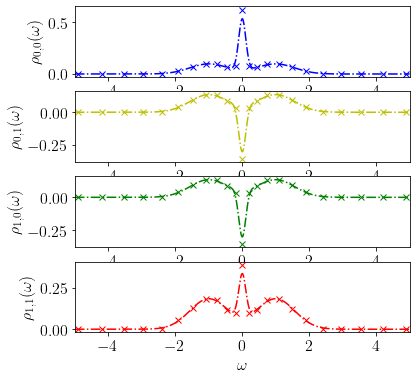

In [17]:
rho_omega_spm = _to_rho_omega(r.x)

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(411)
ax2 = plt.subplot(412, sharex = ax1)
ax3 = plt.subplot(413, sharex = ax1)
ax4 = plt.subplot(414, sharex = ax1)
axes = [ax1, ax2, ax3, ax4]

plt.xlabel(r'$\omega$')
colors = ['b', 'y', 'g', 'r']
plt.xlim([-5,5])
for idx, (i, j) in enumerate(product(range(2),repeat=2)):
    axes[idx].plot(smpl_points, rho_omega_spm[:,i,j], label=f'({i},{j})', color=colors[idx], ls='', marker='x')
    axes[idx].plot(omegas, rho_omega[:,i,j], label='', color=colors[idx], ls='-.')
    axes[idx].set_ylabel(r'$\rho_{' + f'{i},{j}' + '}(\omega)$')